In [43]:
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
import torchvision.transforms as transforms
import numpy as np
import os
from PIL import Image
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
device = "cuda"

In [127]:
model = torchvision.models.googlenet(pretrained=True)
model.eval()
model = model.to(device)
model_feature_map = nn.Sequential(*list(model.children())[:-3])
model_classification = nn.Sequential(*list(model.children())[-3:])
model_finalfc = list(model.children())[-1]
model_finalfc_w = list(model_finalfc.parameters())[0]
model_finalfc_b = list(model_finalfc.parameters())[1]

In [100]:
f = open('../1000.txt')
text1000 = f.read().split("\n")
f.close()

In [46]:

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [135]:

def cam(img_fn):
    image = Image.open(img_fn)
    image = preprocess(image).unsqueeze_(0)
    plt.imshow(image.numpy()[0].transpose(1,2,0))
    plt.show()
    image = image.to(device)
    #output = model(image)
    feature_map = model_feature_map(image)
    #featuremapをGAPして変形してfc
    output = model_finalfc((F.adaptive_avg_pool2d(feature_map,output_size=(1,1))).view(*feature_map.shape[0:2]))
    
    idx = torch.argmax(output.squeeze_(0))
    print(text1000[idx])
    print(feature_map.shape)
    feature_map_shape = feature_map.shape[2:]
    activation_map = model_finalfc_w[idx].matmul(feature_map.view(feature_map.shape[1],-1)).reshape(1,1, *feature_map_shape)
    activation_map = activation_map/torch.max(activation_map)
    activation_map = F.upsample_bilinear(activation_map, image.shape[2:])
    activation_map = activation_map.squeeze_()
    plt.imshow(activation_map.detach().cpu().numpy())
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


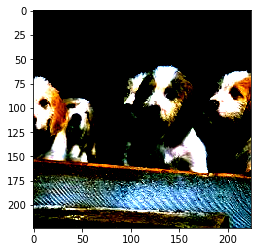

n02096437 Dandie Dinmont, Dandie Dinmont terrier
torch.Size([1, 1024, 7, 7])


/usr/local/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:2562: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")


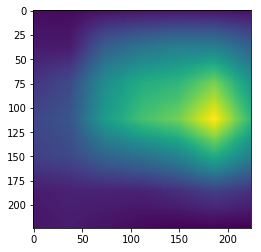

In [136]:
cam("/export/data/dataset/animal/dog/415000.jpg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


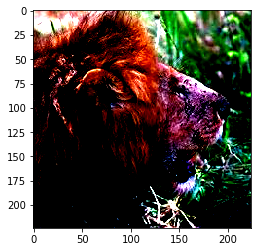

n02129165 lion, king of beasts, Panthera leo


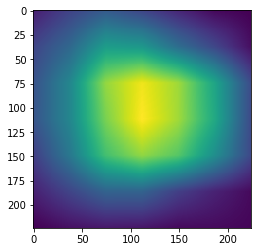

In [120]:
cam("/export/data/dataset/animal/lion/105084.jpg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


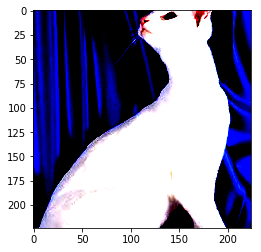

n02124075 Egyptian cat


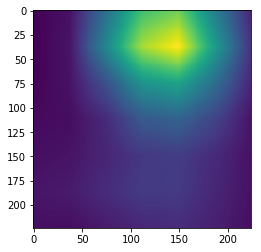

In [121]:
cam("/export/data/dataset/animal/cat/458050.jpg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


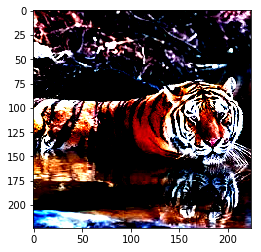

n02129604 tiger, Panthera tigris


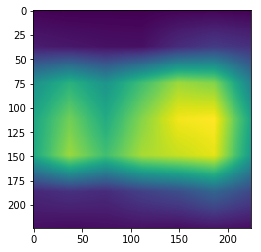

In [122]:
cam("/export/data/dataset/animal/tiger/108002.jpg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


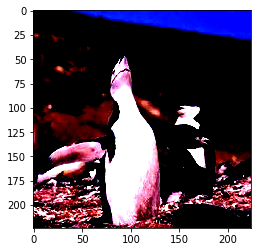

n02056570 king penguin, Aptenodytes patagonica


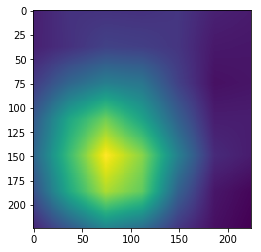

In [123]:
cam("/export/data/dataset/animal/penguin/541049.jpg")

In [163]:

def grad_cam(img_fn):
    image = Image.open(img_fn)
    image = preprocess(image).unsqueeze_(0)
    plt.imshow(image.numpy()[0].transpose(1,2,0))
    plt.show()
    image = image.to(device)
    #output = model(image)
    feature_map = model_feature_map(image)
    feature_map = feature_map.detach()
    feature_map.requires_grad = True
    #featuremapをGAPして変形してfc
    output = model_finalfc((F.adaptive_avg_pool2d(feature_map,output_size=(1,1))).view(*feature_map.shape[0:2]))
    idx = torch.argmax(output.squeeze_(0))
    dydz = torch.zeros((1,1000)).to(device)
    dydz[0,idx] = 1
    output.backward(dydz)
    #1位のラベルのone-hotをバックワードしてfeature mapの勾配を計算
    print(text1000[idx])
    print(feature_map.shape)
    feature_map_shape = feature_map.shape[2:]
    #activation_map = model_finalfc_w[idx].matmul(feature_map.view(feature_map.shape[1],-1)).reshape(1,1, *feature_map_shape)
    channel_weight = F.adaptive_avg_pool2d(feature_map.grad[0],output_size=(1,1)).reshape(-1)
    #feature mapの勾配のチャネルごとの平均値が重要度　それとfeature mapの積を取ってチャネル毎の和
    #を取りreluするとactivation mapの出来上がり
    print(channel_weight.shape) 
    feature_map_shape = feature_map.shape[2:]
    activation_map = channel_weight.matmul(feature_map.view(feature_map.shape[1],-1)).reshape(1,1, *feature_map_shape)
    activation_map = F.relu(torch.sum(feature_map,axis=1))
    
    activation_map = activation_map/torch.max(activation_map)
    activation_map = F.upsample_bilinear(activation_map.unsqueeze(0), image.shape[2:])
    activation_map = activation_map.squeeze_()
    plt.imshow(activation_map.detach().cpu().numpy())
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


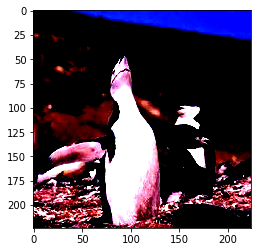

n02056570 king penguin, Aptenodytes patagonica
torch.Size([1, 1024, 7, 7])
torch.Size([1024])


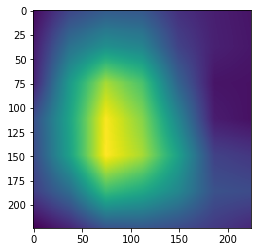

In [164]:
grad_cam("/export/data/dataset/animal/penguin/541049.jpg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


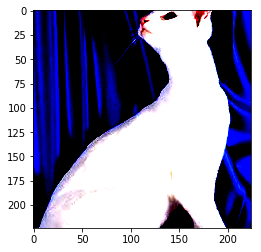

n02124075 Egyptian cat
torch.Size([1, 1024, 7, 7])
torch.Size([1024])


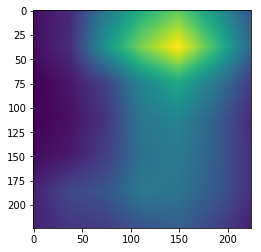

In [165]:
grad_cam("/export/data/dataset/animal/cat/458050.jpg")